In [1]:
import signature
import signature.tensor_algebra as ta

print(signature.__file__)


/Users/phonedegerland/efmgate/external/signature/signature/__init__.py


In [8]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Paramètres
T = 4
shift = 365

lambda_ = 1.5     # vitesse de réversion
sigma = 1.0       # volatilité

# Grille de temps
t_grid = jnp.linspace(-T, T, (T * 2) * 365 + 1)
dt = t_grid[1] - t_grid[0]

# RNG numpy
rng = np.random.default_rng(seed=4843)

# Simulation OU stationnaire 
def simulate_ou(t_grid, rng, lambda_, sigma):
    dt = t_grid[1] - t_grid[0]

    # variance stationnaire
    var_stat = sigma**2 / (2 * lambda_)
    X0 = rng.normal(0, np.sqrt(var_stat))

    dW = rng.normal(0, np.sqrt(dt), size=len(t_grid))
    X = [X0]

    for i in range(1, len(t_grid)):
        X_new = (
            X[-1]
            - lambda_ * X[-1] * dt
            + sigma * dW[i]
        )
        X.append(X_new)

    return jnp.array(X)

X = simulate_ou(t_grid, rng, lambda_, sigma)

## PLOTs 

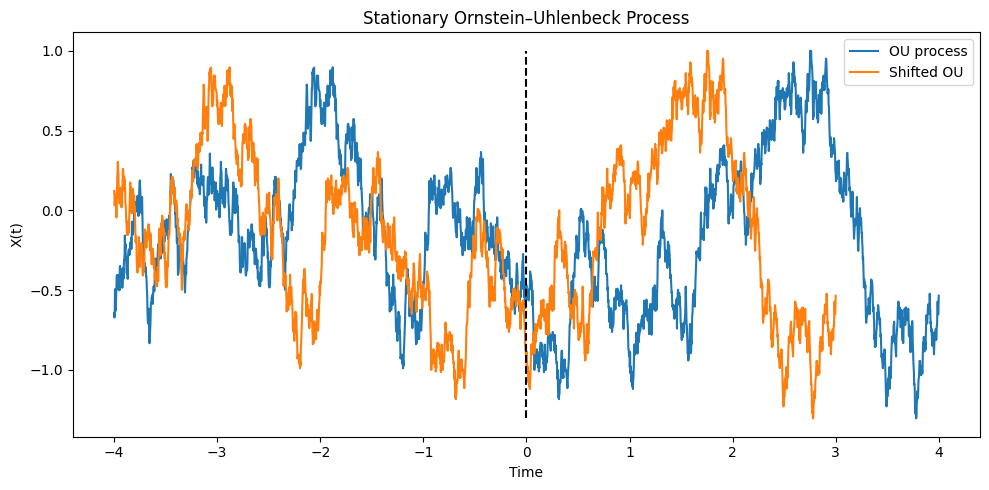

In [9]:

#  Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t_grid, X, label="OU process")
ax.plot(t_grid[:-shift], X[shift:], label="Shifted OU")
ax.vlines(0, X.min(), X.max(), colors="k", linestyles="--")
ax.legend()
ax.set_title("Stationary Ornstein–Uhlenbeck Process")
ax.set_xlabel("Time")
ax.set_ylabel("X(t)")
fig.tight_layout()
plt.show()


## Test Calcul de signature EFM

In [7]:
t_grid_pos = t_grid[t_grid >= 0]
W_pos = X[t_grid >= 0]

path = np.vstack([t_grid, W]).T
path_pos = np.vstack([t_grid_pos, W_pos]).T
dim = path.shape[1]

NameError: name 'W' is not defined

In [10]:
N = 10
Sig = ta.path_to_signature(path=path_pos, trunc=N)

NameError: name 'path_pos' is not defined

In [17]:
Sig

[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  2.73972603e-03  5.47945205e-03 ...  3.99452055e+00
   3.99726027e+00  4.00000000e+00]
 [ 0.00000000e+00 -6.70653341e-03 -1.43988998e-02 ... -1.68293172e+00
  -1.72073623e+00 -1.67547761e+00]
 ...
 [ 0.00000000e+00 -2.07217742e-29 -3.76321969e-26 ...  7.03509659e-05
   2.11058743e-05  8.02826606e-05]
 [ 0.00000000e+00 -2.07217742e-29 -3.76017367e-26 ... -2.50963455e-04
  -2.51868857e-04 -2.52757146e-04]
 [ 0.00000000e+00  5.07245140e-29  1.05567456e-25 ...  5.02229167e-05
   6.27162374e-05  4.80422419e-05]]

In [18]:
# ===============================
# Seeds
# ===============================
import random
import numpy as np
import torch


# ============================================================
# Imports & Seeds
# ============================================================
from EfmGate import EfmLSTM
from data import generate_ou_signal, build_dataset, split_data, r2_score

import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'EfmGate'

In [ ]:


SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# ============================================================
# Data generation
# ============================================================
_, data = generate_ou_signal(T=150, seed=0, kappa=15, theta=0., nu=1.5)
paths, targets = build_dataset(data.reshape(-1, 1))


# ============================================================
# Models
# ============================================================
class EfmLSTMPredictor(nn.Module):
    units: int = 16
    out_size: int = 1
    signature_depth: int = 2
    signature_input_size: int = 5

    @nn.compact
    def __call__(self, x):
        h = EfmLSTM(self.units, self.signature_depth, self.signature_input_size)(x)
        h = EfmLSTM(self.units, self.signature_depth, self.signature_input_size)(h)
        return nn.Dense(self.out_size)(h)


class SimpleLSTMPredictor(nn.Module):
    units: int = 16
    out_size: int = 1

    @nn.compact
    def __call__(self, x):
        """
        x: (batch, T, in_size)
        return: (batch, T, out_size)
        """
        batch_size, T, _ = x.shape
        cell = nn.LSTMCell(features=self.units)

        # ✅ INIT CARRY ROBUSTE (compatible toutes versions flax)
        c0 = jnp.zeros((batch_size, self.units), dtype=x.dtype)
        h0 = jnp.zeros((batch_size, self.units), dtype=x.dtype)
        carry = (c0, h0)

        hs = []
        for t in range(T):
            carry, h = cell(carry, x[:, t, :])
            hs.append(h)

        h_seq = jnp.stack(hs, axis=1)          # (batch, T, units)
        y = nn.Dense(self.out_size)(h_seq)     # (batch, T, out_size)
        return y


# ============================================================
# Generic training (works for both models)
# ============================================================
def train_model_generic(
    model, x_train, y_train, x_val, y_val,
    epochs=10, lr=0.01, batch_size=10,
    patience_es=5, min_delta=1e-5,
    lr_reduce_patience=5, lr_factor=0.25, min_lr=2.5e-5,
    seed=0
):
    params = model.init(jax.random.PRNGKey(seed), x_train)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, x, y):
        y_pred = model.apply(params, x)
        return jnp.mean((y_pred - y) ** 2)

    grad_fn = jax.value_and_grad(loss_fn)

    best_val_loss = float("inf")
    best_params = params
    epochs_no_improve_es = 0
    epochs_no_improve_lr = 0
    current_lr = lr

    num_batches = int(np.ceil(x_train.shape[0] / batch_size))

    for epoch in range(epochs):
        perm = np.random.permutation(x_train.shape[0])
        x_train_shuff = x_train[perm]
        y_train_shuff = y_train[perm]

        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size

            x_batch = x_train_shuff[start:end]
            y_batch = y_train_shuff[start:end]

            loss, grads = grad_fn(params, x_batch, y_batch)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)

            # validation (à chaque batch comme dans ton code)
            val_loss = float(loss_fn(params, x_val, y_val))

            if best_val_loss - val_loss > min_delta:
                best_val_loss = val_loss
                best_params = params
                epochs_no_improve_es = 0
                epochs_no_improve_lr = 0
            else:
                epochs_no_improve_es += 1
                epochs_no_improve_lr += 1

            # reduce LR
            if epochs_no_improve_lr >= lr_reduce_patience:
                current_lr = max(current_lr * lr_factor, min_lr)
                optimizer = optax.adam(current_lr)
                opt_state = optimizer.init(params)
                epochs_no_improve_lr = 0

            # logs
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1} | Val loss: {val_loss:.5f} | LR: {current_lr:.6f}")

            # early stopping
            if epochs_no_improve_es >= patience_es:
                print(f"Early stopping triggered at epoch {epoch+1}")
                return model, best_params

    return model, best_params


# ============================================================
# Plot (single graph with 3 curves)
# ============================================================
def plot_predictions_simple(
    y_true, y_pred_efm, y_pred_simple,
    run_num, n_ahead=1,
    r2_efm=None, rmse_efm=None,
    r2_simple=None, rmse_simple=None
):
    plt.figure(figsize=(10, 6))

    y_true_np = np.array(y_true).flatten()
    y_efm_np = np.array(y_pred_efm).flatten()
    y_simple_np = np.array(y_pred_simple).flatten()

    plt.plot(y_true_np, 'b-', linewidth=2, label='Vraies valeurs', alpha=0.8)
    plt.plot(y_efm_np, 'r--', linewidth=2, label='EFM-LSTM', alpha=0.8)
    plt.plot(y_simple_np, 'g-.', linewidth=2, label='LSTM simple', alpha=0.8)

    plt.xlabel('Index temporel', fontsize=12)
    plt.ylabel('Valeur', fontsize=12)

    title = f'Prédictions vs Vraies valeurs - Run {run_num} (n_ahead={n_ahead})'
    if (r2_efm is not None and rmse_efm is not None and
        r2_simple is not None and rmse_simple is not None):
        title += (
            f"\nEFM: R²={r2_efm:.4f}, RMSE={rmse_efm:.4f} | "
            f"Simple: R²={r2_simple:.4f}, RMSE={rmse_simple:.4f}"
        )
    plt.title(title, fontsize=14)

    plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# Main training loop
# ============================================================
n_aheads = [1]

results_r2_efm = {n: [] for n in n_aheads}
results_rmse_efm = {n: [] for n in n_aheads}
results_r2_simple = {n: [] for n in n_aheads}
results_rmse_simple = {n: [] for n in n_aheads}

all_predictions = []

for n_ahead in n_aheads:
    for run in range(3):
        print(f"\n{'='*50}")
        print(f"Run {run+1}, n_ahead={n_ahead}")
        print('='*50)

        # Split
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(paths, targets)
        X_train, y_train = jnp.array(X_train), jnp.array(y_train)
        X_val, y_val = jnp.array(X_val), jnp.array(y_val)
        X_test, y_test = jnp.array(X_test), jnp.array(y_test)

        print(f"Shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"Shapes - X_test:  {X_test.shape},  y_test:  {y_test.shape}")

        # ----------------------------
        # Train EFM-LSTM
        # ----------------------------
        efm_model = EfmLSTMPredictor()
        efm_model, efm_params = train_model_generic(
            efm_model, X_train, y_train, X_val, y_val,
            epochs=10, lr=0.01, batch_size=10,
            patience_es=5, min_delta=1e-5,
            lr_reduce_patience=5, lr_factor=0.25, min_lr=2.5e-5,
            seed=0
        )

        # ----------------------------
        # Train Simple LSTM
        # ----------------------------
        simple_model = SimpleLSTMPredictor(units=16)
        simple_model, simple_params = train_model_generic(
            simple_model, X_train, y_train, X_val, y_val,
            epochs=10, lr=0.01, batch_size=10,
            patience_es=5, min_delta=1e-5,
            lr_reduce_patience=5, lr_factor=0.25, min_lr=2.5e-5,
            seed=0
        )

        # ----------------------------
        # Predictions
        # ----------------------------
        y_pred_efm = efm_model.apply(efm_params, X_test)
        y_pred_simple = simple_model.apply(simple_params, X_test)

        print(f"y_pred_efm shape:    {y_pred_efm.shape}")
        print(f"y_pred_simple shape: {y_pred_simple.shape}")
        print(f"y_test shape:        {y_test.shape}")

        # ----------------------------
        # Metrics
        # ----------------------------
        r2_efm = r2_score(y_test, y_pred_efm)
        rmse_efm = jnp.sqrt(jnp.mean((y_pred_efm - y_test) ** 2))

        r2_simple = r2_score(y_test, y_pred_simple)
        rmse_simple = jnp.sqrt(jnp.mean((y_pred_simple - y_test) ** 2))

        results_r2_efm[n_ahead].append(float(r2_efm))
        results_rmse_efm[n_ahead].append(float(rmse_efm))
        results_r2_simple[n_ahead].append(float(r2_simple))
        results_rmse_simple[n_ahead].append(float(rmse_simple))

        print(f"Run {run+1} | EFM     R²: {r2_efm:.4f}, RMSE: {rmse_efm:.4f}")
        print(f"Run {run+1} | Simple  R²: {r2_simple:.4f}, RMSE: {rmse_simple:.4f}")

        # ----------------------------
        # Plot (3 curves, simple LSTM in GREEN)
        # ----------------------------
        y_test_flat = np.array(y_test).flatten()
        y_pred_efm_flat = np.array(y_pred_efm).flatten()
        y_pred_simple_flat = np.array(y_pred_simple).flatten()

        plot_predictions_simple(
            y_test_flat, y_pred_efm_flat, y_pred_simple_flat,
            run_num=run+1, n_ahead=n_ahead,
            r2_efm=float(r2_efm), rmse_efm=float(rmse_efm),
            r2_simple=float(r2_simple), rmse_simple=float(rmse_simple)
        )

        all_predictions.append({
            "run": run + 1,
            "n_ahead": n_ahead,
            "y_true": y_test_flat,
            "y_pred_efm": y_pred_efm_flat,
            "y_pred_simple": y_pred_simple_flat,
            "r2_efm": float(r2_efm),
            "rmse_efm": float(rmse_efm),
            "r2_simple": float(r2_simple),
            "rmse_simple": float(rmse_simple),
        })

# BROUILONS

In [20]:
# Essayer avec un point
from .src.efmgate.models.efm_gate import EfmGate

ImportError: attempted relative import with no known parent package